In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [68]:
# Load the Excel file with all sheets into a dictionary of DataFrames
ecommerce_data = pd.read_excel('E-commerce_data.xlsx', sheet_name=None, engine='openpyxl')

# Check the sheet names (tables) available in the file
print("Sheet names:", ecommerce_data.keys())

# Access each table (sheet) by its name, for example:
customers_df = ecommerce_data['customers']
transactions_df = ecommerce_data['transactions']
cities_df = ecommerce_data['cities']
genders_df = ecommerce_data['genders']
merchants_df = ecommerce_data['merchants']
branches_df = ecommerce_data['branches']

# Print the first few rows of each table to verify
print(customers_df.head())
print(transactions_df.head())


Sheet names: dict_keys(['customers', 'genders', 'cities', 'transactions', 'branches', 'merchants'])
   customer_id  join_date  city_id  gender_id
0            1 2022-01-08        7          1
1            2 2023-05-02       20          2
2            3 2023-05-14       15          1
3            4 2022-11-25       11          2
4            5 2023-04-26        8          1
   transaction_id  customer_id transaction_date transaction_status  \
0               1          733       2024-05-11         subscribed   
1               2          631       2023-05-15             burned   
2               3          309       2022-11-13         subscribed   
3               4          695       2024-01-26         subscribed   
4               5          288       2022-10-12             burned   

  coupon_name  burn_date  branch_id  
0     uNY-568        NaT          7  
1     kBx-219 2023-06-04          5  
2     PLG-122        NaT          7  
3     Wzf-897        NaT          2  
4     qGb-428

In [69]:
# Merge tables
# 1. Merge customers with genders and cities
customers_df = customers_df.merge(genders_df, on='gender_id', how='left')
customers_df = customers_df.merge(cities_df, on='city_id', how='left')

In [70]:
customer_transactions = customers_df.merge(transactions_df, on='customer_id', how='left')


In [71]:
# Feature Engineering
# 1. Encode gender_name and city_name
le = LabelEncoder()
customer_transactions['gender_encoded'] = le.fit_transform(customer_transactions['gender_name'])
customer_transactions['city_encoded'] = le.fit_transform(customer_transactions['city_name'])

In [72]:
# 2. Coupon usage frequency (per customer)
coupon_usage = customer_transactions.groupby('customer_id').agg(
    coupon_usage_frequency=('transaction_id', 'count'),
    claimed_ratio=('transaction_status', lambda x: (x == 'claimed').mean()),
    burnt_ratio=('transaction_status', lambda x: (x == 'burnt').mean())
).reset_index()

In [74]:
# Merge back with the customer data
customer_data = customers_df.merge(coupon_usage, on='customer_id', how='left')

In [77]:
customer_data['gender_encoded'] = customer_transactions['gender_encoded']
customer_data['city_encoded'] = customer_transactions['city_encoded']

In [79]:
# Feature Selection
features = customer_data[['gender_encoded', 'city_encoded', 'coupon_usage_frequency', 'claimed_ratio', 'burnt_ratio']]


In [80]:
# Scaling the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [81]:
# Model Development - KMeans Clustering
# Use Elbow method to find optimal number of clusters (K)
inertia = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

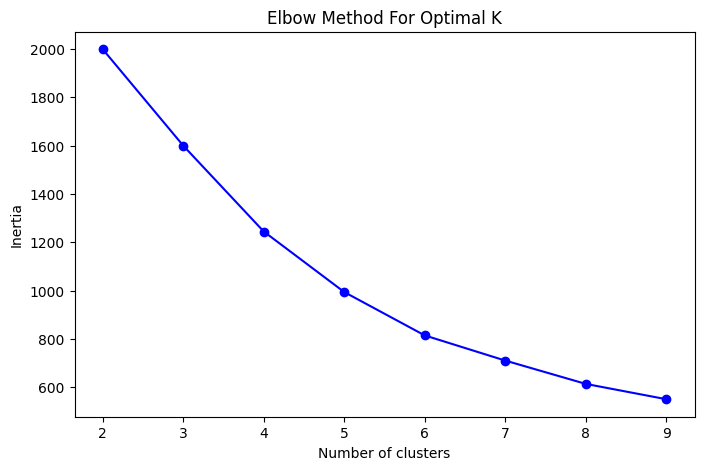

In [82]:
# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.show()

In [83]:
# Choose the optimal K (e.g., 4 from elbow curve) and fit the model
kmeans = KMeans(n_clusters=4, random_state=42)
customer_data['cluster'] = kmeans.fit_predict(scaled_features)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [84]:
# Model Evaluation - Silhouette Score
silhouette_avg = silhouette_score(scaled_features, customer_data['cluster'])
print(f'Silhouette Score for KMeans: {silhouette_avg}')

Silhouette Score for KMeans: 0.345923306031555


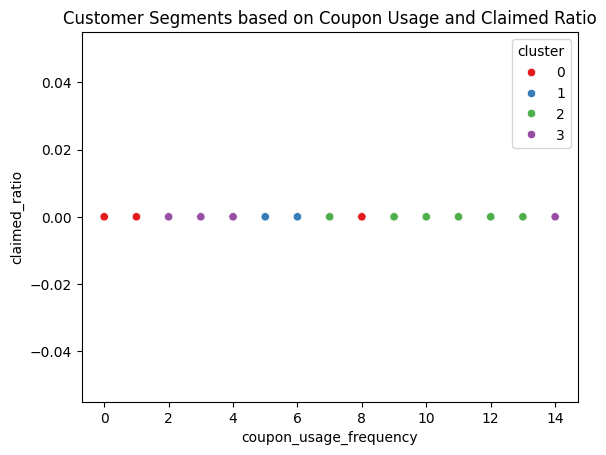

In [85]:
# Analyze the Segments
# Visualize clusters based on selected features (gender_encoded, city_encoded)
sns.scatterplot(data=customer_data, x='coupon_usage_frequency', y='claimed_ratio', hue='cluster', palette='Set1')
plt.title('Customer Segments based on Coupon Usage and Claimed Ratio')
plt.show()

In [86]:
# Summary of each cluster
cluster_summary = customer_data.groupby('cluster').agg({
    'gender_encoded': 'mean',
    'city_encoded': 'mean',
    'coupon_usage_frequency': 'mean',
    'claimed_ratio': 'mean',
    'burnt_ratio': 'mean'
}).reset_index()

print(cluster_summary)

   cluster  gender_encoded  city_encoded  coupon_usage_frequency  \
0        0        0.000000     14.271255                5.000000   
1        1        1.000000      6.797753                3.456929   
2        2        0.996078     11.647059                6.752941   
3        3        0.000000      3.896104                4.848485   

   claimed_ratio  burnt_ratio  
0            0.0          0.0  
1            0.0          0.0  
2            0.0          0.0  
3            0.0          0.0  
